In [79]:
import glob 
import pandas as pd
from dateutil import parser
from gensim.utils import simple_preprocess
import re
import matplotlib.pyplot as plt

In [244]:
# load data
df = pd.concat([pd.read_csv(file) for file in glob.glob("data/*.csv")], ignore_index=True, sort=True)

# retain relevant columns
df = df[['date', 'text']]

# convert date to appropriate format
df['date'] = [parser.parse(date).strftime('%Y-%m-%d') for date in df['date']]

# lowercase text columns
df['text'] = df.apply(lambda x: (x.text).lower(),axis=1)
df.shape

(3391, 2)

In [245]:
# filter texts containing ph, philippines
df = df.loc[[True if any([True for keyword in ['confirm'] if keyword in text]) 
             else False for text in df['text']], :]

df = df.loc[[True if any([True for keyword in ['ph', 'philippines'] if keyword in text]) 
             else False for text in df['text']], :]

df = df.loc[[True if any([True for keyword in ['virus', 'ncov'] if keyword in text]) 
             else False for text in df['text']], :]

# extract number before or after the word 'confirmed', else set it to 0
df['confirmed_count'] = df.apply(lambda x: int(re.findall('[\d] [Cc]onfirm', x.text)[0][0:2]) \
                                 if len(re.findall('[\d] [Cc]onfirm', x.text)) >= 1 \
                                 else (int(re.findall('[Cc]onfirmed [\d]', x.text)[0][-2:]) 
                                       if len(re.findall('[Cc]onfirmed [\d]', x.text)) >= 1 else 
                                       (int(re.findall('[Cc]onfirms [\d]', x.text)[0][-2:])
                                        if  len(re.findall('[Cc]onfirms [\d]', x.text)) >= 1 
                                        else 0)), axis=1)

In [246]:
std = df.groupby('date').agg({'confirmed_count':'std'}).sort_values(by='date').reset_index().\
        rename(columns={'confirmed_count':'stds'})
df = df.merge(std, on='date', how='left')
#df = df.groupby('date')['confirmed_count'].max().reset_index().sort_values(by='date').reset_index()

In [247]:
g = df.groupby('date')
df = g.apply(lambda x: x.confirmed_count.mean() if x.stds.min() >= 1.75 else x.confirmed_count.max()).reset_index()

In [248]:
# cumulative sum of confirmed_count
df[0] = df[0].cumsum(axis=0)

Total Confirmed Cases:136.0


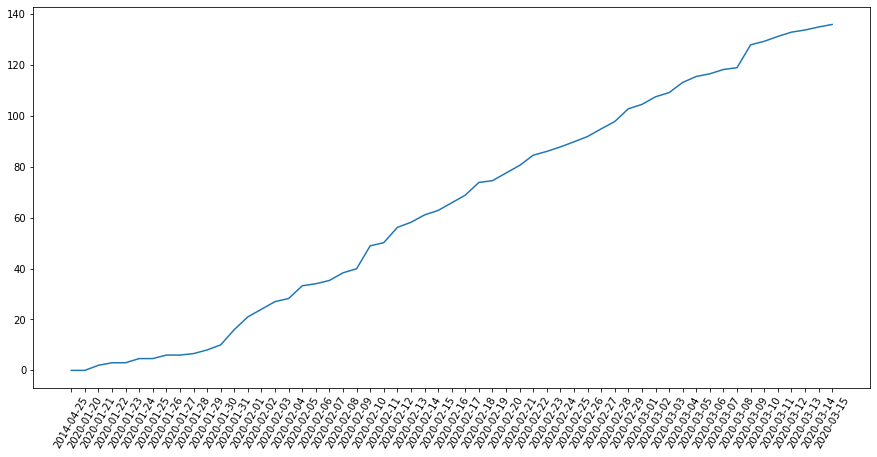

In [250]:
fig, ax = plt.subplots(figsize=(15,7))
plt.plot(df['date'], df[0])
plt.xticks(rotation=60)
print('Total Confirmed Cases:' + str(round(df.loc[df.shape[0] - 1, 0])))